In [1]:
# Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf #https://pypi.org/project/yfinance/
from scipy.stats import uniform
from scipy.stats import binom
from scipy.stats import norm
from scipy.stats import pareto
from scipy.optimize import minimize

In [18]:
# Functions and classes

class plotting:
    '''
    Class for plotting. 
    '''
    def __init__(self,ax,myxlabel,myylabel,font_sizes,leg):
        self.ax = ax # Axis
        self.myxlabel = myxlabel # x-label
        self.myylabel = myylabel # y-label
        self.font_sizes = font_sizes # font-sizes 
        self.leg = leg # Legend 

    def add_labels(self):
        '''
        Adds labels, grid and optional legend to plot.
        Inputs: 
        ax - plotting object
        myxlabel - xlabel string
        myylabel - ylabel string
        font_sizes - array of size 5 of fontsizes for xlabel string, 
        ylabel string, xticks, yticks and legend
        leg - if 1 put in the legend, otherwise do not
        Output: ax - plotting object with the added inputs
        '''
        self.ax.set_xlabel(self.myxlabel,fontsize=self.font_sizes[0])
        self.ax.set_ylabel(self.myylabel,fontsize=self.font_sizes[1])
        self.ax.grid(color='grey', linestyle='--', linewidth=0.5)
        self.ax.tick_params(axis='x', labelsize=self.font_sizes[2])
        self.ax.tick_params(axis='y', labelsize=self.font_sizes[3])
        if(self.leg==1):
            self.ax.legend(fontsize=self.font_sizes[4])
        return self.ax

class return_functions:
    
     def __init__(self,stock_prices):
        self.stock_prices = stock_prices

     def get_index_array(self):
        '''
        This function outputs array that indexes only 
        to the not nans in the stock prices. MAY NOT BE NECESSARY
        '''
        ind_not_nan=np.where(np.isnan(self.stock_prices)==False)[0]
        return ind_not_nan

     def returns(self):
        '''
        Finds returns of array of stock prices.
        Input: stock prices object
        Output: float array of returns
        '''
        ind_not_nan = self.get_index_array()
        stock_prices_f=np.asarray(self.stock_prices[ind_not_nan],float) 
        return stock_prices_f[1:]/stock_prices_f[:-1]
    
     def log_returns(self):
        '''
        Finds log returns of array of stock prices.
        See https://gregorygundersen.com/blog/2022/02/06/log-returns/
        Input: stock prices object
        Output: float array of log returns
        '''
        returns = self.returns()
        return np.log(returns)

def get_stock_prices_dates(data):
    '''
    Inputs: data - dataframe of stock
    Outputs: dates of stock, time interval of stocks in years, stock prices
    '''
    # Get dates which is the index column of the data frame
    data['Date']=data.index
    dates=data['Date']
    
    # Get number of years of historic stock data
    start_date = dates.iloc[0]
    end_date = dates.iloc[-1]
    difference_in_years = relativedelta(end_date, start_date).years
    
    # Stock prices as float
    stock_type = 'Close'
    stock_prices = np.asarray(data[stock_type],float)

    return dates, difference_in_years, stock_prices

def plot_stock_info(data,stock):
    '''
    Inputs: data - dataframe of stock, stock - stock code.
    Outputs: plot the stock price, returns and log returns.
    '''

    dates, difference_in_years, stock_prices =  get_stock_prices_dates(data)
    stock_type = 'Close'
    
    returns_c = return_functions(stock_prices) # Enter stock-prices to returns class
    returns = returns_c.returns() # Get log-returns
    log_returns = returns_c.log_returns() # Get log-returns
    

    # Plot historical daily (closed) stock price, log returns and k-generalised and normal fits to tails of log returns ##############
    fig, ax = plt.subplots(2,2,figsize=(10,5)) 

    if difference_in_years <= 10:
        ax[0,0].xaxis.set_major_locator(mdates.YearLocator(1)) # Sorts issue with repeating years over small range
        ax[0,1].xaxis.set_major_locator(mdates.YearLocator(1)) # Sorts issue with repeating years over small range
        ax[1,0].xaxis.set_major_locator(mdates.YearLocator(1)) # Sorts issue with repeating years over small range
    
    ax[0,0].plot(dates,stock_prices,label=stock+' '+stock_type)
    font_sizes = [10,10,10,10,12]
    leg=1
    labels=['Date','Stock price',font_sizes,leg]
    plotting(ax[0,0],*labels).add_labels()
    ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Set dates to year only for x-axis
    
    ax[0,1].plot(dates[1:],returns,label=stock)
    leg=0
    labels=['Date','Returns',font_sizes,leg]
    plotting(ax[0,1],*labels).add_labels()
    ax[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Set dates to year only for x-axis 

    ax[1,0].plot(dates[1:],log_returns,label=stock)
    leg=0
    labels=['Date','Log-Returns',font_sizes,leg]
    plotting(ax[1,0],*labels).add_labels()
    ax[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Set dates to year only for x-axis 

    ax[1,1].axis('off')
    
    plt.tight_layout()


class stock_statisics:

    def up_down(data,stock):
        '''
        Inputs: stock data and stock name
        Outputs: array with 1 if stock gone up (returns >1) and 0 
        if stock stayed the same or gone down (returns <=1)
        '''
        dates, difference_in_years, stock_prices =  get_stock_prices_dates(data)
        stock_type = 'Close'
        returns_c = return_functions(stock_prices) # Enter stock-prices to returns class
        returns = returns_c.returns() # Get returns
        n = len(returns)
        up_down = np.zeros(n)
        ind = np.argwhere(returns>1).reshape(1,-1)
        n1 = len(ind)
        up_down[ind] = np.ones(n1)
        up_down = np.asarray(up_down,int)
        return up_down

    def up_down_stats(data,stock):
        '''
        Inputs: stock data and stock name
        Outputs: prints no. of returns, no. of returns that have gone up and this percentage,
        whether this is significant at the 0.05 level testing with the binomial distribution
        '''
        ud = stock_statisics.up_down(data,stock)

        n = len(ud)
        no_gone_up = np.sum(ud)
        no_gone_down_or_stayed_same = n - no_gone_up
        
        if no_gone_up < n/2:
            sig = binom.cdf(no_gone_up,n,p = 0.5)
        else:
            sig = binom.sf(no_gone_up,n,p = 0.5)
            
        sig_level = 0.05

        print(f'There are {n} returns of stock {stock}.')
        
        print(f'Of which {no_gone_up} have gone up equivalent to {np.round(no_gone_up/n*100,2)}%.')

        if sig < sig_level:
            print(f'This is significant at the {sig_level} level.')
        else:
            print(f'This is not significant at the {sig_level} level.')

def plot_cum_pos_returns(data,stock):
    '''
    Inputs: stock data and stock name
    Outputs: plot of cumulative proportion of positive returns
    '''
    fig, ax = plt.subplots(figsize=(6,4)) 
    dates, difference_in_years, stock_prices =  get_stock_prices_dates(data)
    if difference_in_years <= 10:
            ax.xaxis.set_major_locator(mdates.YearLocator(1)) # Sorts issue with repeating years over small range
    d = stock_statisics.up_down(data,stock)
    c = np.ones(len(d))
    ax.plot(dates[1:],np.cumsum(d)/np.cumsum(c))
    ax.axhline(0.5)
    font_sizes = [10,10,10,10,12]
    leg=0
    labels=['Date','Proportion of +ve returns',font_sizes,leg]
    plotting(ax,*labels).add_labels()

In [20]:
# Download the Yahoo stock data using yfinance

# Stock codes:

# stock = '^NYA'
# stock = '^IXIC'
# stock = '^FTSE'
# stock = 'AAPL'
# stock = 'BTC-GBP'
# stock = 'ABNB'
stock = 'GC=F'

data = yf.download(stock, period="max") # Dataframe for stock for maximum period. Note sometimes a stock fails to download!

[*********************100%%**********************]  1 of 1 completed


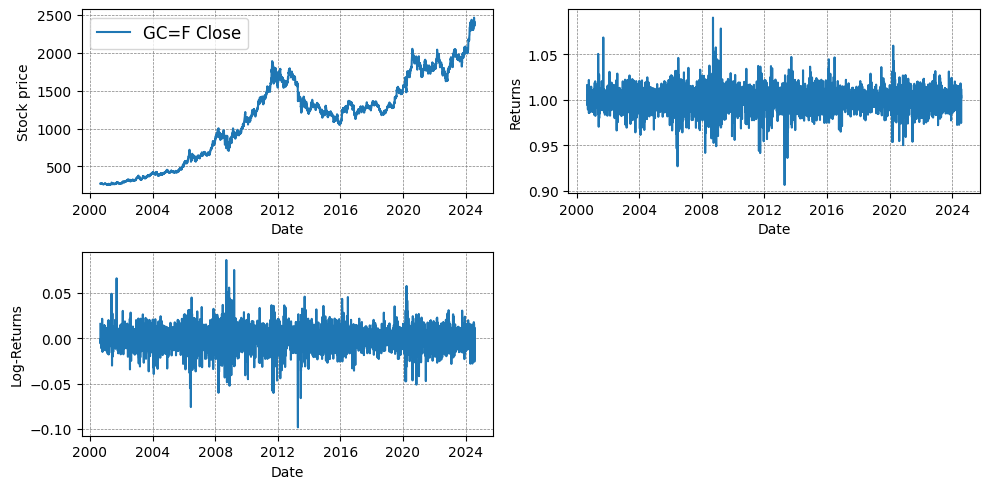

In [21]:
plot_stock_info(data,stock)

In [22]:
stock_statisics.up_down_stats(data,stock)

There are 5998 returns of stock GC=F.
Of which 3138 have gone up equivalent to 52.32%.
This is significant at the 0.05 level.


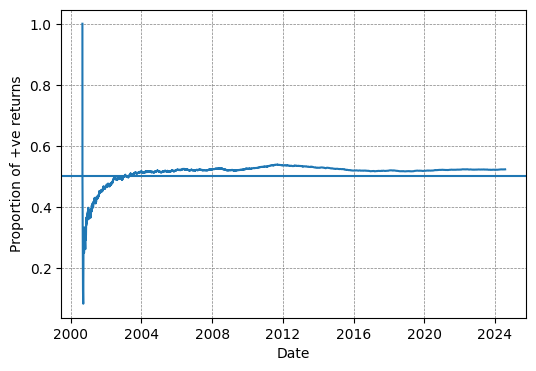

In [23]:
plot_cum_pos_returns(data,stock)